# Data visualization and budget set up

In [1]:
# pip install prophet

In [2]:
# pip install pathos

Import packages

In [3]:
import sys
sys.path.append(str('/home/jupyter/SearchForecasting/'))

from configparser import ConfigParser

from repo.MyConfigParser import MyConfigParser

from repo.LoadData import DataLoader
from repo.BuildModel import GenerateModelFile, CreateModel
from repo.Accuracy import AccuracyCalculator, ProphetParameterSearch, PlotAccuracyCharts
from repo.FileGenerator import *

import matplotlib.pyplot as plt


In [4]:
pd.set_option('display.float_format', '{:.6f}'.format)

initial config file to config_dict

In [5]:
updated_config = ConfigParser()
config_in_path = "/home/jupyter/SearchForecasting/India/June 2024 Update/config ups india.ini"
updated_config.read(config_in_path)

getdict = MyConfigParser()
config_dict=getdict.GetDict(updated_config)
region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]

05.27.2024


Query daily data

In [6]:
daily_df = GetBQData(training_query, _input, _output)
daily_df['day'] = daily_df.ds.dt.day
daily_df['month'] = daily_df.ds.dt.month
daily_df['year'] = daily_df.ds.dt.year

daily_df

/home/jupyter/SearchForecasting/repo/QueryingData.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  search_df.fillna(method = 'ffill', inplace = True)


,region,market,funnel,account_type,ds,X,y,day,month,year
0,Europe,India,-,Desktop,2022-01-01,46.150000,49.000000,1,1,2022
1,Europe,India,-,Desktop,2022-01-02,27.130000,20.000000,2,1,2022
2,Europe,India,-,Desktop,2022-01-03,216.810000,199.000000,3,1,2022
3,Europe,India,-,Desktop,2022-01-04,866.240000,245.000000,4,1,2022
4,Europe,India,-,Desktop,2022-01-05,693.360000,202.000000,5,1,2022
...,...,...,...,...,...,...,...,...,...,...
1335,Europe,India,-,Mobile & Tablet,2024-04-25,994.650000,1.000000,25,4,2024
1336,Europe,India,-,Mobile & Tablet,2024-04-26,963.850000,1.000000,26,4,2024
1337,Europe,India,-,Mobile & Tablet,2024-04-27,560.260000,1.000000,27,4,2024
1338,Europe,India,-,Mobile & Tablet,2024-04-29,1151.070000,3.000000,29,4,2024


In [7]:
daily_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   region        1340 non-null   object        
 1   market        1340 non-null   object        
 2   funnel        1340 non-null   object        
 3   account_type  1340 non-null   object        
 4   ds            1340 non-null   datetime64[ns]
 5   X             1340 non-null   float64       
 6   y             1340 non-null   float64       
 7   day           1340 non-null   int32         
 8   month         1340 non-null   int32         
 9   year          1340 non-null   int32         
dtypes: datetime64[ns](1), float64(2), int32(3), object(4)
memory usage: 89.1+ KB


In [8]:
daily_df.ds.max()

Timestamp('2024-04-30 00:00:00')

In [9]:
# pre_optimization_budget = daily_df[['year','X']].loc[(daily_df.month == 4) & 
#                                                      (daily_df.year >= 2020) & (daily_df.day >= 25)].groupby(['year']).sum().mean()


year_2022 = daily_df.loc[(daily_df['ds'] >= '2022-04-28') & (daily_df['ds'] <= '2022-06-04'), 'X'].sum()
year_2023 = daily_df.loc[(daily_df['ds'] >= '2023-04-27') & (daily_df['ds'] <= '2023-06-03'), 'X'].sum()
pre_optimization_budget = (year_2022 + year_2023) / 2

pre_optimization_budget

33587.630000000005

In [10]:
df = daily_df.copy()
df.market = region
df = df.groupby(['region', 'market', 'account_type', 'funnel', 'ds']).sum().reset_index()

In [11]:
# remove rows without date or conversion quantity
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]

In [12]:
# df.loc[(df['ds'] >= '2021-08-01')&(df['ds'] <= '2021-10-31') & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].groupby(['month']).sum(numeric_only=True)
# df.loc[((df['ds'] >= '2019-03-01') & (df['ds'] <= '2019-08-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].groupby(['month']).sum(numeric_only=True)

In [13]:
df = df[~df[['ds', 'y']].isin([np.nan, np.inf, -np.inf]).any(axis=1)]
#df = df[df.ds < cutoff_month]
# remove inactive days
df.drop(df[((df['ds'] >= '2021-08-01')&(df['ds'] <= '2021-10-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
       axis = 0, inplace = True)
df.drop(df[((df['ds'] >= '2019-03-01')&(df['ds'] <= '2019-08-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Brand'))].index,
       axis = 0, inplace = True)

df.drop(df[((df['ds'] >= '2021-07-01')&(df['ds'] <= '2021-12-31')) & ((df.account_type == 'Bing Ads') & (df.funnel == 'Generic'))].index,
       axis = 0, inplace = True)

In [16]:
df

,region,market,account_type,funnel,ds,X,y,day,month,year,year_month
0,Europe,India,Desktop,-,2022-01-01,46.150000,49.000000,1,1,2022,2022-01
1,Europe,India,Desktop,-,2022-01-02,27.130000,20.000000,2,1,2022,2022-01
2,Europe,India,Desktop,-,2022-01-03,216.810000,199.000000,3,1,2022,2022-01
3,Europe,India,Desktop,-,2022-01-04,866.240000,245.000000,4,1,2022,2022-01
4,Europe,India,Desktop,-,2022-01-05,693.360000,202.000000,5,1,2022,2022-01
...,...,...,...,...,...,...,...,...,...,...,...
1335,Europe,India,Mobile & Tablet,-,2024-04-25,994.650000,1.000000,25,4,2024,2024-04
1336,Europe,India,Mobile & Tablet,-,2024-04-26,963.850000,1.000000,26,4,2024,2024-04
1337,Europe,India,Mobile & Tablet,-,2024-04-27,560.260000,1.000000,27,4,2024,2024-04
1338,Europe,India,Mobile & Tablet,-,2024-04-29,1151.070000,3.000000,29,4,2024,2024-04


In [17]:
df['year_month'] = df['ds'].dt.to_period('M')

Desktop = df.loc[df.account_type == 'Desktop'].groupby(['year_month'])[['year_month','X','y']].sum(numeric_only=True).reset_index()

In [18]:
Desktop

,year_month,X,y
0,2022-01,12997.440000,4500.000000
1,2022-02,12969.080000,4482.000000
2,2022-03,19338.940000,6634.000000
3,2022-04,25092.950000,5189.000000
4,2022-05,25254.350000,6272.000000
5,2022-06,26195.770000,7054.000000
6,2022-07,23926.190000,5491.000000
7,2022-08,26726.240000,5660.000000
8,2022-09,26611.460000,5878.000000
9,2022-10,21338.140000,5091.000000


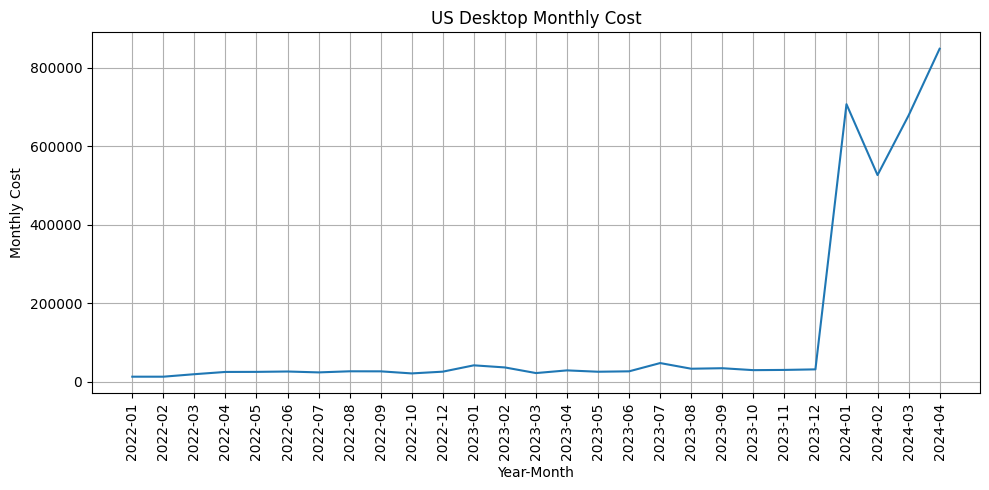

In [19]:
# Plotting the time series graph
plt.figure(figsize=(10, 5))
plt.plot(Desktop['year_month'].astype(str), Desktop['X'])  # Convert year_month to string for plotting
plt.title('US Desktop Monthly Cost')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Cost')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()

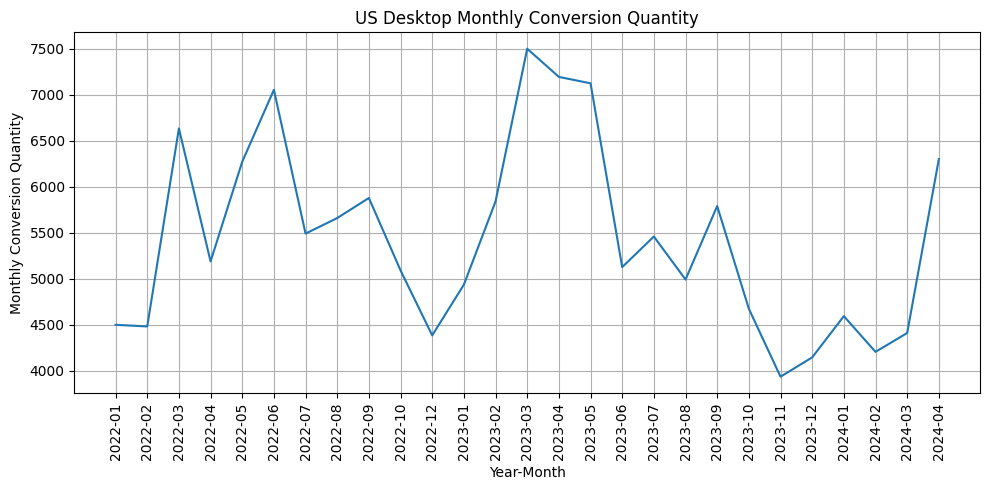

In [20]:
# Plotting the time series graph
plt.figure(figsize=(10, 5))
plt.plot(Desktop['year_month'].astype(str), Desktop['y'])  # Convert year_month to string for plotting
plt.title('US Desktop Monthly Conversion Quantity')
plt.xlabel('Year-Month')
plt.ylabel('Monthly Conversion Quantity')
plt.grid(True)
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout
plt.show()